In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
models = ["model1", "model2", "model3"]
sub_cohort = ['dbd_tier1_snvs', 'large_rare_deletions', 'large_rare_duplications', 'nejm_deletions', 'nejm_duplications']
pheno_cols = ['Full_scale_IQ', 'ABCL_CBCL_external', 'ABCL_CBCL_internal', 'SRS_raw', 'RBS_R', 'DCDQ', 'BMI_zscore']
variables = [
    ["SCZ_PRS", "All_rare_del_var"],
    ["SCZ_PRS", "Rare_Deleterious_SNVs", "`Genes DEL`", "`Genes DUP`", "`STRs exonic`"],
    ["SCZ_PRS", "Rare_Deleterious_SNVs_LOEUF", "`DELs LOEUF<0.35`", "`DUPs LOEUF<0.35`", "`STRs exonic LOEUF<0.35`"]
    ]

In [17]:
def read_stats(store_dir, m, s, pc, v):
    filename = os.path.join(store_dir, "_".join([m, s, pc, v]) + ".tsv").replace("`", "")
    df = pd.read_csv(filename, sep="\t")
    lor, pval, r2 = df.loc[df.Variable==v, ["Log Odds Ratio", "P-value", "R2"]].values.flatten()
    return lor, pval, r2


def make_dataframe(store_dir, m, s, pcs, vs):
    data_dict = {
        "phenotypes": [],
        "variables": [],
        "log odds ratio": [],
        "p value": [],
        "R2": []
    }

    for pc in pcs:
        all_model_file = os.path.join(store_dir, "_".join([m, s, pc + ".tsv"]))
        all_model_df = pd.read_csv(all_model_file, sep="\t")
        data_dict["phenotypes"].append(pc)
        data_dict["variables"].append("all")
        data_dict["log odds ratio"].append(np.nan)
        data_dict["p value"].append(np.nan)
        data_dict["R2"].append(all_model_df.loc[0, "R2"])

        for v in vs:
            lor, pval, r2 = read_stats(store_dir, m, s, pc, v)
            data_dict["phenotypes"].append(pc)
            data_dict["variables"].append(v)
            data_dict["log odds ratio"].append(lor)
            data_dict["p value"].append(pval)
            data_dict["R2"].append(r2)
    df = pd.DataFrame(data_dict)
    return df


def make_heatmaps(store_dir, ms, scs, pcs, vs_list):
    fig, axes = plt.subplots(len(scs), len(ms), figsize=(28, 36))
    for j,(m, vs) in enumerate(zip(ms, vs_list)):
        for i,s in enumerate(scs):
            df = make_dataframe(store_dir, m, s, pcs, vs)
            plot_df = df.pivot(index="variables", columns="phenotypes", values="R2")
            annot_df = df.pivot(index="variables", columns="phenotypes", values="p value").fillna(1.)
            annot_df = (annot_df<0.05).replace({True: "*", False: ""})
            sns_ax = sns.heatmap(
                data=plot_df, 
                cmap="RdBu_r",
                annot=annot_df,
                annot_kws={"fontsize": 24},
                fmt='',
                square=True,
                cbar_kws={"shrink": 0.5},
                ax=axes[i, j]
                )
            sns_ax.set_xticklabels(sns_ax.get_xticklabels(), rotation=45, horizontalalignment='right')
            sns_ax.set_yticklabels(sns_ax.get_yticklabels(), rotation=0, horizontalalignment='right')
            sns_ax.set_title(f"{m}-{s}")
            sns_ax.set_xlabel("")
            sns_ax.set_ylabel("")
    return

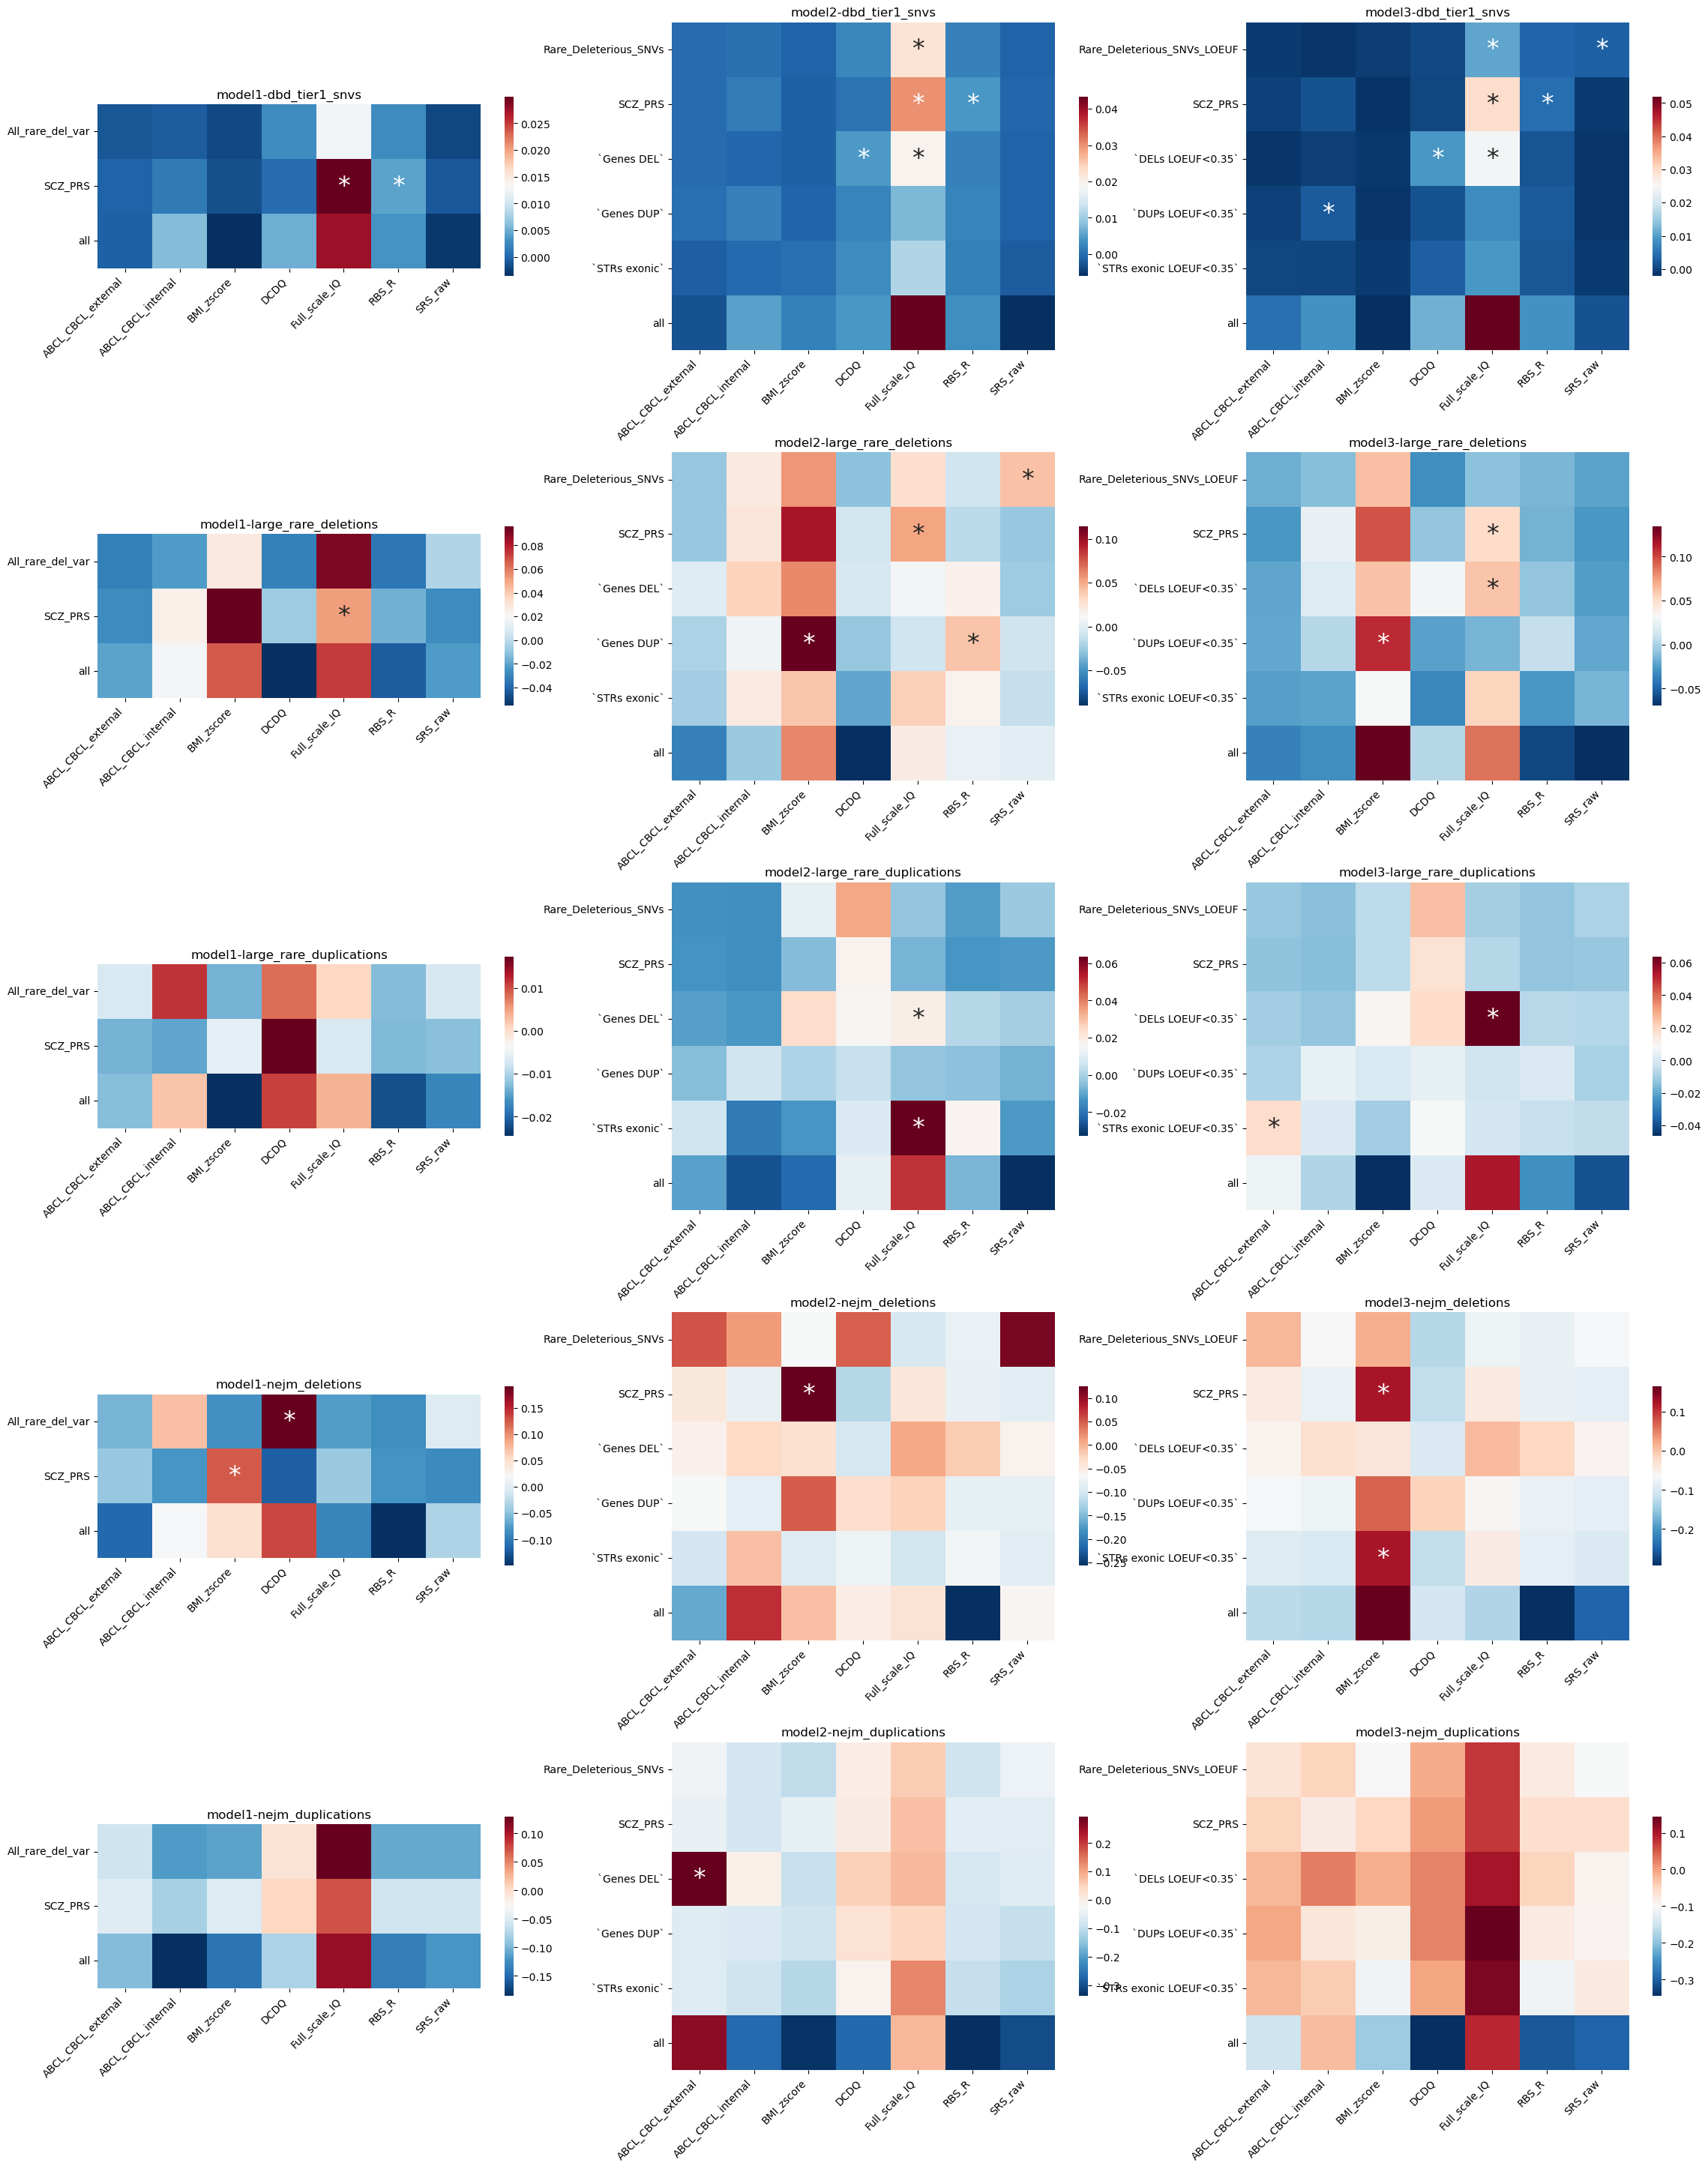

In [18]:
make_heatmaps("../data/statistics/", models, sub_cohort, pheno_cols, variables)